In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from IPython.display import display,HTML
from fastai.text.all import *


     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 1.2 MB 36.0 MB/s 
     |████████████████████████████████| 189 kB 49.0 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 304 kB/s 
Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:

path = untar_data(URLs.YELP_REVIEWS)
train_csv = path/'train.csv'
train = pd.read_csv(train_csv, header = None, names=('label','text'))
valid_csv = path/'test.csv'
valid = pd.read_csv(valid_csv, header = None, names=('label','text'))

In [ ]:
train.head(2)

,label,text
0,5,"dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first. really, what more do you need? i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."
1,2,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I..."


I've tried to create different dataloaders for train and test files, however, due to the size of files it takes ages to construct them. That is why I decided just to join train and test together, put them into the datablock and use splitter for furhte development. 

In [ ]:
print (f'Let\'s define the original train/test split ration - {valid.shape[0]/(valid.shape[0]+train.shape[0])}')

Let's define the original train/test split ration - 0.07142857142857142


That looks rather small, so let' increase ratio at least at 80/20

In [ ]:
test

<function fastcore.test.test>

In [ ]:
joined_DF = pd.concat([train,valid])
joined_DB = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                     splitter=RandomSplitter(0.2),
                     get_x=ColReader('text')
                     )

Whole dataset is too big and I have strong feelings, that Colab will ran off RAM/GPU runtime, so I'll use only a part of the data

In [ ]:
part_DF = joined_DF.sample(n=5000) 

In [ ]:
part_loader = joined_DB.dataloaders(part_DF, bs = 32)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
part_loader.show_batch(max_n = 3)

,text,text_
0,"xxbos xxmaj yay , got ta love the location and the food ! xxmaj the xxmaj thai is xxunk and tasty … and the bar is a nice place to sit at if you want to talk with a small group of friends . \n\n xxmaj over all my xxunk here was joyful and tasty xxbos xxmaj we had the xxmaj brussels xxmaj sprouts and they were delicious . xxmaj just a","xxmaj yay , got ta love the location and the food ! xxmaj the xxmaj thai is xxunk and tasty … and the bar is a nice place to sit at if you want to talk with a small group of friends . \n\n xxmaj over all my xxunk here was joyful and tasty xxbos xxmaj we had the xxmaj brussels xxmaj sprouts and they were delicious . xxmaj just a touch"
1,"to xxmaj mandalay xxmaj place for dinner . xxmaj but if they keep up the good work , it could compete with some of the better properties . xxbos xxmaj save your money . xxmaj you can get twice the food at half the price at other near by mexican fast food places . xxmaj enchiladas had a really odd flavor . xxmaj the red sauce that was inside them tastes as","xxmaj mandalay xxmaj place for dinner . xxmaj but if they keep up the good work , it could compete with some of the better properties . xxbos xxmaj save your money . xxmaj you can get twice the food at half the price at other near by mexican fast food places . xxmaj enchiladas had a really odd flavor . xxmaj the red sauce that was inside them tastes as if"
2,they could break down anytime . xxbos i seem to go to xxmaj xxunk 's xxmaj stadium at least once every time i go to xxmaj vegas and yet i still never learn my lesson . \n xxmaj let me start by saying the design of the place is really cool . xxup xxunk after xxup xxunk throughout the place and a sports book to make your xxunk . i would warn,could break down anytime . xxbos i seem to go to xxmaj xxunk 's xxmaj stadium at least once every time i go to xxmaj vegas and yet i still never learn my lesson . \n xxmaj let me start by saying the design of the place is really cool . xxup xxunk after xxup xxunk throughout the place and a sports book to make your xxunk . i would warn you


In [ ]:
learn_lm = language_model_learner(
    part_loader, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learn_lm.fit_one_cycle(1, 5e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.147022,4.038417,0.264424,56.736450,02:51


In [ ]:
learn_lm.save('First_epoch')

Path('models/First_epoch.pth')

In [ ]:
learn_lm.unfreeze()

SuggestedLRs(valley=0.0003311311302240938)

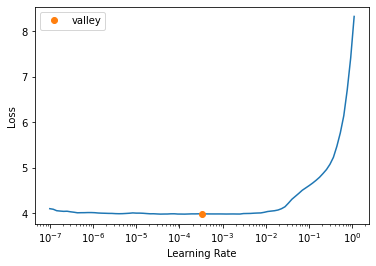

In [ ]:
learn_lm.lr_find()

In [ ]:
learn_lm.fit_one_cycle(2, 1e-5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.969671,4.017027,0.266662,55.535748,03:15
1,3.953327,4.010962,0.267237,55.199921,03:15


In [ ]:
learn_lm.save_encoder('fine_tuned')

In [ ]:
TEXT = "This subject was very interesting"
N_WORDS = 40
N_SENTENCES = 1
predictions = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

print("\n".join(predictions))

This subject was very interesting to me . There was great experience in the environment , without being sick . They did not have enough hits to get the diagnosis from anything . Hopefully , a chance when they need someone to


The quality of text generator is very low, but I've trained it on really small part of data. If I use my local machine it wouldn't be a problem, however Keras doesn't support AWD_LSTM, so I had to use Fastai in Colab, which has restriction to the GPU usage time

In [ ]:
class_DB = DataBlock(
    blocks=(TextBlock.from_df('text',seq_len=72, vocab=part_loader.vocab),CategoryBlock),
    get_x = ColReader('text'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(0.2)).dataloaders(valid,bs = 32, seq_len = 72)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
class_DB.show_batch(max_n=3)

,text,category
0,"xxbos i booked a xxunk rental car for $ xxunk and i had my colleague rent the car on the 1st day because i was n't flying into xxup lv until the day after . xxmaj there was a little problem because my colleague is only 24 years old , and he does n't meet the 25 + rule . xxmaj so , for everyday , we have to pay an extra $ 14 because of that , which i totally understand . xxup but , now all of a sudden , the $ xxunk turned into almost $ xxunk ! \n\n xxmaj so at this time , my coworker is already in xxup lv at xxmaj fox , and xxmaj i 'm still in xxup la . xxmaj he has no mode of xxunk to the hotel and xxup ces xxmaj xxunk trade show , so xxmaj i 'm",1
1,"xxbos xxmaj take any lounge / club but make it during the daytime + outside at a nice pool + there you have xxmaj tao xxmaj beach . xxmaj and , of course , true to any clubbing - like experience , your xxunk of how good your time was is xxunk on \n▁ xxup a ) how hot / fun / young the crowd is that day \n▁ + \n▁ xxup b ) how much you drink \n xxmaj our group of all girls came on a xxmaj sunday early afternoon + pretty much had a good time considering the crowd was young + good - looking + we each had at least a few drinks in our system . xxmaj if you 're looking for a place to just lay out + relax , xxmaj tao xxmaj beach is n't for you . xxmaj you can go to",4
2,"xxbos 7 / 4 / 12 \n\n xxmaj i 'd visited a few years ago , but it was too busy , and i did n't have time to wait 30 to 45 minutes to be seated , so i left . xxmaj i 've had xxup xxunk xxunk to try since . xxmaj when i heard word that xxup xxunk was offering a xxmaj fourth of xxmaj july special ( buy one entree , get the second for $ 4 ) , i thought it was time to see what all the xxunk was about . \n\n xxmaj two weeks beforehand , i made plans with a cousin to have lunch here on the 4th . xxmaj what a surprise to find out that xxup xxunk was serving brunch , as well , and we breakfast lovers were thrilled to check out the breakfast items . xxmaj while our",3


On this step I've ran out off the GPU usage limit on Colab. I've tried to use 50k data sample. But even 50k was too much for training (about 1 hour per epoch) while the accuracy was total disaster - soething near 0.28 - 0.29.  So I've retrained everything on much smaller part, just to showm how this approach has to be performed.


In [ ]:
model = text_classifier_learner(
    class_DB, AWD_LSTM, drop_mult=0.5, 
    metrics=accuracy).to_fp16()
model.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.293016,1.164284,0.493300,08:14
1,1.238114,1.139581,0.505300,08:13


In [ ]:
model.show_results(max_n=5)

,text,category,category_
0,"xxbos xxmaj came here on their 2nd soft opening day . xxmaj there was a xxup lot of waiters / waitresses waiting at the door and greeted us the second the door opened . xxmaj two of my friend 's had already arrived by the time , my friend and i had gotten there ( oops i took the long way there apparently … xxup xxunk or rather the slow way haha ) . \n\n xxmaj first impressions - xxup lots of people working . xxmaj probably to get used to the environment and process . xxmaj decor . xxmaj very simple . xxmaj red and xxmaj white . xxmaj first thought i had , "" why does this remind me of xxmaj in n xxmaj out … . ? "" xxup lol anyway xxmaj design almost kept like how it was when xxmaj cafe de xxmaj xxunk existed .",3,3
1,"xxbos xxrep 3 * xxmaj it 's a really long review , i hope it does n't xxunk you from reading it xxrep 3 * \n\n\n i really wish yelp gave the option of giving 1 / 2 stars . . . \n\n xxmaj and so with that opening sentence , here is my review : \n\n a group of friends and i went to xxmaj dal xxmaj xxunk out of sheer xxunk . xxmaj it was a xxmaj saturday night and well , being xxmaj vegas , all the good restaurants were already booked . xxmaj now , i know that we could have gone to any restaurant but we were starving and that was the only place we could get . xxmaj the restaurant is at xxmaj the xxmaj palazzo and located in the lowest level of the hotel . xxmaj it was actually really hard to find",1,2
2,"xxbos xxmaj trying to do more with less . xxmaj that sums up the xxup sls . xxmaj the whole experience feels xxunk . i was in town for 3 weeks for various xxunk events . xxmaj my girlfriend decided to visit me over xxmaj halloween weekend . xxmaj we stayed at xxmaj mandalay xxmaj bay on xxmaj friday and the xxup sls xxmaj saturday . xxmaj our experience at xxmaj mandalay was great as always but for some reason rates were insane for the night after xxmaj halloween , not the actual holiday . i was able to book a "" suite "" at the xxup sls for the cost of a king at xxmaj mandalay . xxup sls is at the xxmaj xxunk part of the strip . xxmaj casino xxunk from xxmaj las xxmaj vegas blvd . and main entrance is in the back off of xxmaj",2,3
3,"xxbos xxmaj first off i would like to say that our experience was like night and day compared to the last time we were here . xxmaj it 's funny that i went back and read my last review and i was surprised to see that i had ordered a filet again . i guess i must be a xxunk of habit . xxmaj my tastes have not changed , but the service and quality of xxup xxunk sure has . \n xxmaj let me start off saying that i made reservations weeks in advance . i reserved a booth like last time , and wanted this to be a special xxmaj saturday xxmaj night xxmaj mother 's xxmaj day xxmaj dinner ! xxmaj things just did not pan out that way . xxmaj as we drove up there were no more handicap parking spots available . i asked the",1,1
4,"xxbos i do n't expect a fancy xxunk of amazing service , offerings of exotic produce or a team of personal shoppers xxunk over me when i go to the grocery store . xxmaj given that grocery shopping is already the xxunk of my life , i have really low expectations for the place where i purchase my impressive assortment of top ramen food products . \n\n xxmaj seriously , xxmaj i 'm not shopping for organic baby prawn xxunk and goose liver xxunk ' … i just want to get in and purchase my run of the mill poor person foods like canned beans and frozen dinners . xxmaj so when i say low expectations , i mean xxup really low expectations . \n\n xxmaj so it really says something about the xxmaj smith 's that i would rather saw off my own foot than shop for my failure",1,1


In [ ]:
model_freeze = learn.load_encoder('fine_tuned') 
model_freeze.freeze_to(-2)
model_freeze.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time


So, once again I ran out of Colab GPU usage time. I don't have enough time to re-train all of these staff, so I won't have freezing/unfreezing part.

In [ ]:
model_freeze.unfreeze()
model_freeze.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

NameError: ignored

In [ ]:
model_freeze.show_results(max_n=5)

NameError: ignored